## Forecasting SmartMeter Energy Consumption Data in London Households

#### Aim 
To forecast energy consumption for London households during the following year and identify the day when peak consumption would occur.

#### Data
- Energy consumption readings (kWh per half hour) for 5,567 London Households between November 2011 and February 2014. 
- Two groups of customers:
    - Subgroup 1: ~1100 customers subjected to Dynamic Time of Use (dToU) energy prices throughout 2013.
    - Subgroup 2: ~4500 customers on a flat rate tariff (of 14.228pence/kWh).

#### Method    
- Facebook's open source Prophet package
    - it's user friendly and produces easy-to-interpret outputs.
    - it uses GAMs, which are more flexible than e.g. ARIMA models, which assume constant mean and variance - not good for increasing/decreasing trends also can't handle missing data.
    - GAMS work by summing smooth functions so don't have linearity assumption

In [32]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### As the dataset is large, import as chunks, process and save to pandas df

In [5]:
# Import dataset in chunks using Pandas TextFileReader object
csv_name = 'C:/Users/User/Documents/my_code_files/Exercises/Forecasting London energy consumption Oct 2017/smart_meter_data/Power-Networks-LCL-June2015(withAcornGps)v2.csv'

text_reader = pd.read_csv(csv_name, usecols=['LCLid', 'stdorToU', 'KWH/hh (per half hour) ','DateTime'], 
                          chunksize=50000, iterator = True) # iterator=TRUE means you can select a specific number of rows to view/operate on.

In [ ]:
# summarise each chunk and append to list
list_of_chunks = []

for chunk in text_reader:
    
    # filter out the ~1100 households on a variable tariff
    chunk = chunk.loc[chunk['stdorToU'] == 'Std']
    
    # rename kwh and convert to float / numeric data type
    chunk = chunk.rename(columns = {'KWH/hh (per half hour) ':'kwh'})
    chunk['kwh'] = pd.to_numeric(chunk['kwh'], errors='coerce')
     
    # get date from datetime
    chunk['DateTime'] =  pd.to_datetime(chunk['DateTime'], format='%Y-%m-%d %H:%M:%S.%f')
    chunk['day'] = pd.to_datetime(chunk['DateTime'].apply(lambda x: x.date()))
    
    # compute total daily consumption for each household
    chunk = chunk.groupby(['LCLid', 'day']).agg({'kwh': sum}).reset_index()
    
    list_of_chunks.append(chunk)

In [252]:
# save list of summarised chunks as a pandas df
df = pd.DataFrame()
df = pd.concat(list_of_chunks)  

In [253]:
# save pandas dataframe as CSV file
df.to_csv('daily_kwh_per_household.csv')

### Calculate mean consumption across households and prepare for prophet

In [299]:
### To import the data frame in a new Jupyter session:
df = pd.read_csv('daily_kwh_per_household.csv')

# calculate mean daily consumption across all households
mean_daily_consumption = df.groupby(['day']).agg({'kwh': [min, max, sum, "mean", "std", "mad"]})

# rename columns
mean_daily_consumption.columns = ["_".join(x) for x in mean_daily_consumption.columns.ravel()]

mean_daily_consumption.head()

,kwh_min,kwh_max,kwh_sum,kwh_mean,kwh_std,kwh_mad
day,,,,,,
2011-12-16,3.971,44.766,71.816,17.954000,18.614419,13.406000
2011-12-17,1.989,38.394,250.605,11.933571,9.624420,7.605374
2011-12-18,4.775,43.388,398.283,18.965857,11.386446,8.938313
2011-12-19,2.223,53.213,627.333,13.637674,10.807953,7.970517
2011-12-20,0.632,45.351,715.106,11.350889,8.669051,6.425330


In [300]:
# save to csv
# mean_daily_consumption.to_csv('mean_daily_consumption.csv')

In [127]:
# to import means etc from csv in a new Jupyter session:
mean_daily_consumption = pd.read_csv('mean_daily_consumption.csv')
mean_daily_consumption = mean_daily_consumption.sort_values(by='day')
mean_daily_consumption.head()

,day,kwh_min,kwh_max,kwh_sum,kwh_mean,kwh_std,kwh_mad
0,2011-12-16,3.971,44.766,71.816,17.954000,18.614419,13.406000
1,2011-12-17,1.989,38.394,250.605,11.933571,9.624420,7.605374
2,2011-12-18,4.775,43.388,398.283,18.965857,11.386446,8.938313
3,2011-12-19,2.223,53.213,627.333,13.637674,10.807953,7.970517
4,2011-12-20,0.632,45.351,715.106,11.350889,8.669051,6.425330


In [128]:
# rename for prophet
mean_daily_consumption['ds'] = mean_daily_consumption['day']
mean_daily_consumption['y'] = mean_daily_consumption['kwh_mean']

# select relevant columns
mdc = mean_daily_consumption[['ds','y']]
mdc.head()

,ds,y
0,2011-12-16,17.954000
1,2011-12-17,11.933571
2,2011-12-18,18.965857
3,2011-12-19,13.637674
4,2011-12-20,11.350889


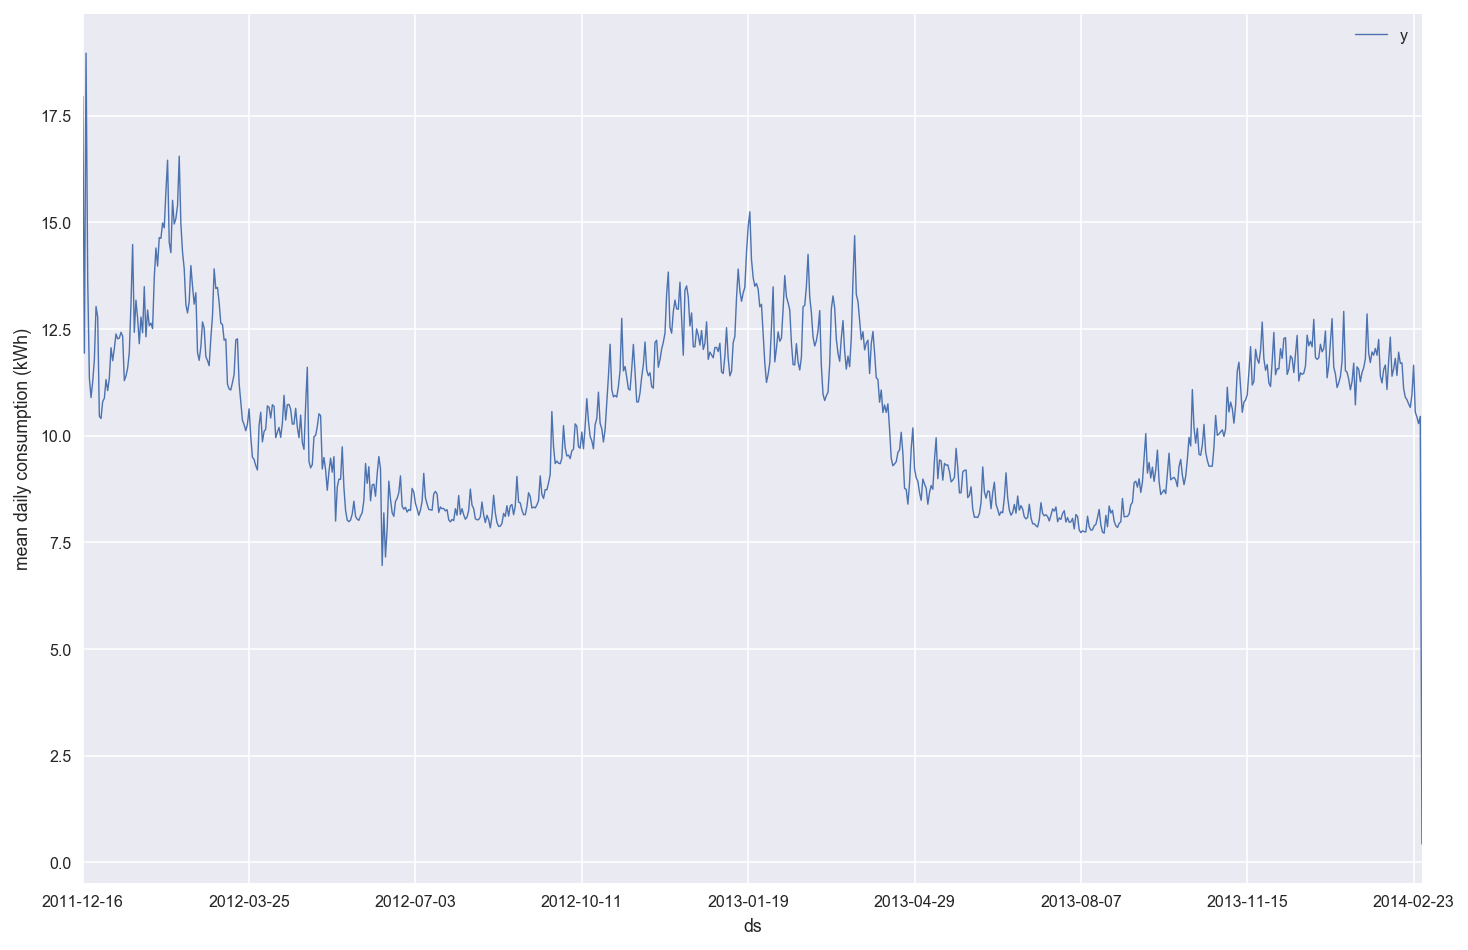

In [129]:
# plot
axes = mdc.set_index('ds').plot(figsize=(12, 8))
axes.set_ylabel('mean daily consumption (kWh)')

plt.show()

In [130]:
# make additive model
m = Prophet() # sticking with default uncertainty interval of 80%
m.fit(mdc)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [133]:
# make forecast
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1166,2015-02-24
1167,2015-02-25
1168,2015-02-26
1169,2015-02-27
1170,2015-02-28


In [134]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1166,2015-02-24,6.909574,5.692350,8.027344
1167,2015-02-25,6.819714,5.708506,7.956127
1168,2015-02-26,6.723326,5.586460,7.809062
1169,2015-02-27,6.645064,5.539211,7.718086
1170,2015-02-28,6.899074,5.763433,8.106428


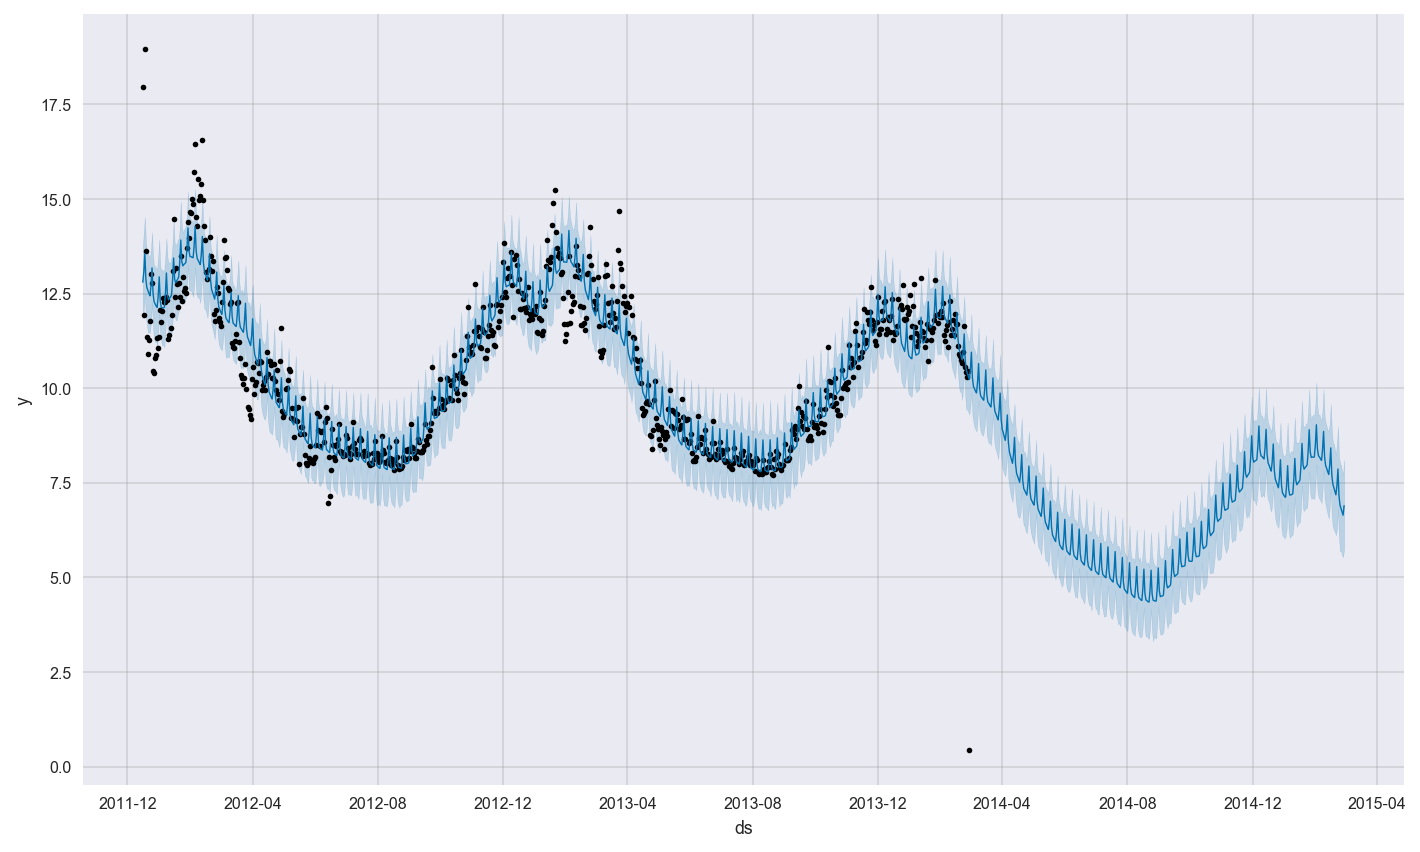

In [137]:
m.plot(forecast, uncertainty=True);

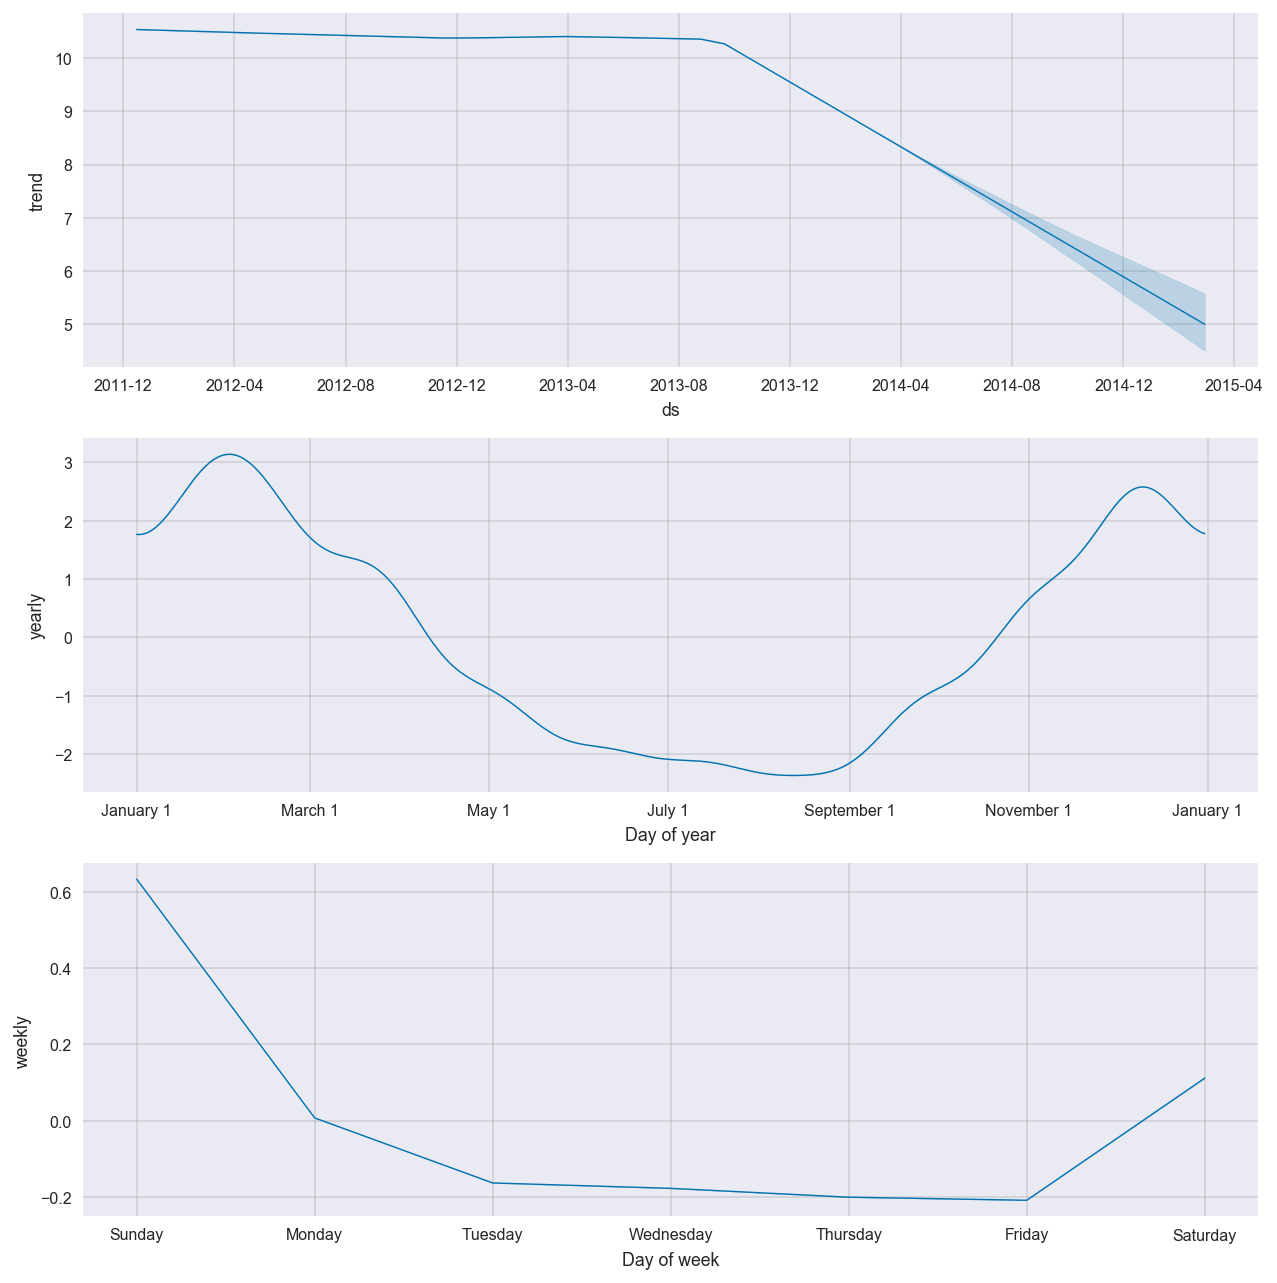

In [25]:
# plot seasonal components
m.plot_components(forecast);

Consumption seems to be dropping over time. It is higher in winter months and at weekends.

### Validate the model using simulated historical forecasts
(Cross validation requires random samples so not appropriate for time series models)

In [29]:
# divide data into monthly (30 day) training segments and use each segment to predict values in subsequent month
df_cv = cross_validation(m, horizon = '30 days')
df_cv.head()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonal

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonal

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-03-26,10.831625,9.309655,12.313914,9.988109,2012-03-25
1,2012-03-27,10.479931,8.997622,11.970807,9.499421,2012-03-25
2,2012-03-28,10.404647,8.908562,11.837662,9.442299,2012-03-25
3,2012-03-29,10.171889,8.723316,11.725053,9.299761,2012-03-25
4,2012-03-30,10.645572,9.204967,12.077202,9.197027,2012-03-25


In [112]:
df_cv_sorted = df_cv.sort_values(by='ds')

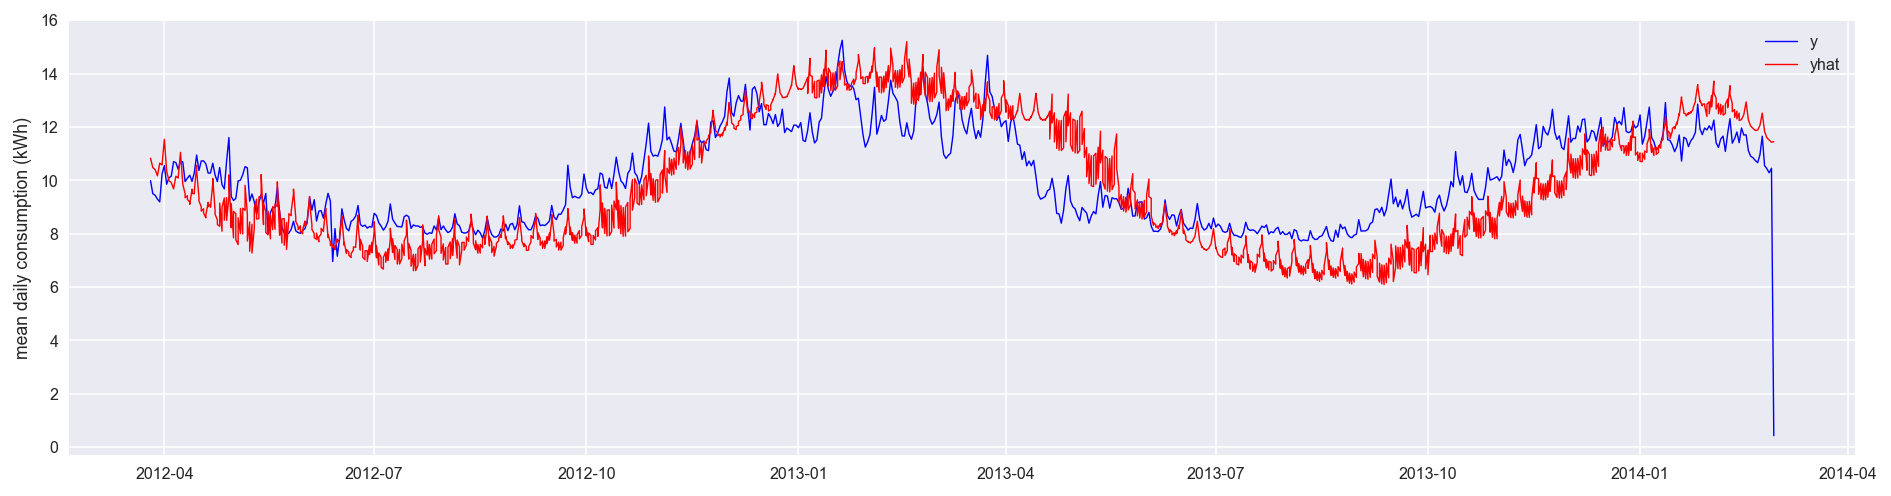

In [118]:
fig, axes = plt.subplots(figsize=(16,4))
axes.plot(np.array(df_cv_sorted['ds']), np.array(df_cv_sorted['y']), 'b', label="y")
axes.plot(np.array(df_cv_sorted['ds']), np.array(df_cv_sorted['yhat']), 'r', label='yhat')
axes.set_ylabel('mean daily consumption (kWh)')
axes.legend();

There is a lag between actual and predicted consumption...

In [119]:
# better to plot absolute prediction error - absolute difference between y and yhat

In [154]:
# view date range of forecast
min(forecast['ds']), max(forecast['ds'])

(Timestamp('2011-12-16 00:00:00'), Timestamp('2015-02-28 00:00:00'))

In [172]:
# select last year in forecast
forecasted_dates = forecast.sort_values(by='ds').tail(365) 

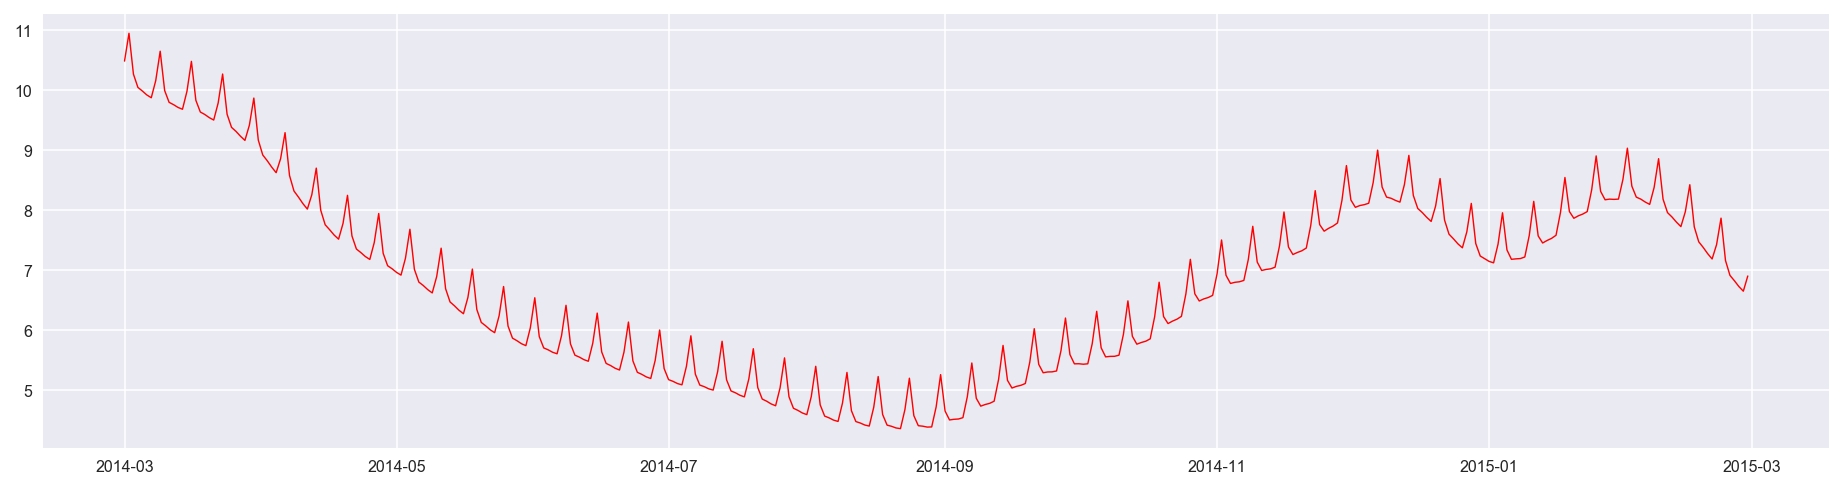

In [170]:
# plot the forecasted year
forecasted_dates = forecasted_dates.sort_values(by='ds', ascending=False)
fig, axes = plt.subplots(figsize=(16,4))
axes.plot(np.array(forecasted_dates['ds']), np.array(forecasted_dates['yhat']), 'r')

In [173]:
# show df to see which day has highest predicted consumption
forecasted_dates = forecasted_dates.sort_values(by='yhat', ascending=False) # sort descending by predicted consumption
forecasted_dates.head(10)

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
807,2014-03-02,8.636273,8.636273,8.636273,9.882309,11.956362,2.316859,2.316859,2.316859,2.316859,2.316859,2.316859,0.634543,0.634543,0.634543,1.682315,1.682315,1.682315,10.953131
814,2014-03-09,8.565975,8.565790,8.566251,9.668213,11.608944,2.087554,2.087554,2.087554,2.087554,2.087554,2.087554,0.634543,0.634543,0.634543,1.453011,1.453011,1.453011,10.653530
806,2014-03-01,8.646315,8.646315,8.646315,9.539485,11.449771,1.842219,1.842219,1.842219,1.842219,1.842219,1.842219,0.111419,0.111419,0.111419,1.730799,1.730799,1.730799,10.488534
821,2014-03-16,8.495678,8.493742,8.498070,9.477696,11.410801,1.988480,1.988480,1.988480,1.988480,1.988480,1.988480,0.634543,0.634543,0.634543,1.353936,1.353936,1.353936,10.484158
828,2014-03-23,8.425381,8.420644,8.430406,9.323581,11.309143,1.847042,1.847042,1.847042,1.847042,1.847042,1.847042,0.634543,0.634543,0.634543,1.212498,1.212498,1.212498,10.272423
808,2014-03-03,8.626230,8.626230,8.626230,9.294662,11.227094,1.644792,1.644792,1.644792,1.644792,1.644792,1.644792,0.006974,0.006974,0.006974,1.637817,1.637817,1.637817,10.271022
813,2014-03-08,8.576018,8.575933,8.576124,9.205554,11.188254,1.586239,1.586239,1.586239,1.586239,1.586239,1.586239,0.111419,0.111419,0.111419,1.474820,1.474820,1.474820,10.162257
809,2014-03-04,8.616188,8.616188,8.616188,9.103154,11.078244,1.433424,1.433424,1.433424,1.433424,1.433424,1.433424,-0.163948,-0.163948,-0.163948,1.597372,1.597372,1.597372,10.049612
815,2014-03-10,8.555933,8.555565,8.556480,9.036487,10.922845,1.441067,1.441067,1.441067,1.441067,1.441067,1.441067,0.006974,0.006974,0.006974,1.434093,1.434093,1.434093,9.997000
810,2014-03-05,8.606145,8.606145,8.606145,8.968633,11.017897,1.382845,1.382845,1.382845,1.382845,1.382845,1.382845,-0.178126,-0.178126,-0.178126,1.560971,1.560971,1.560971,9.988991


## Demand will peak on 2nd March 2014 and this matches the plot above.
But this was the first day of the predicted year. Now look at latest 6 months to predict peak in the following winter.

In [174]:
# select last year in forecast
forecasted_dates = forecast.sort_values(by='ds').tail(180) 

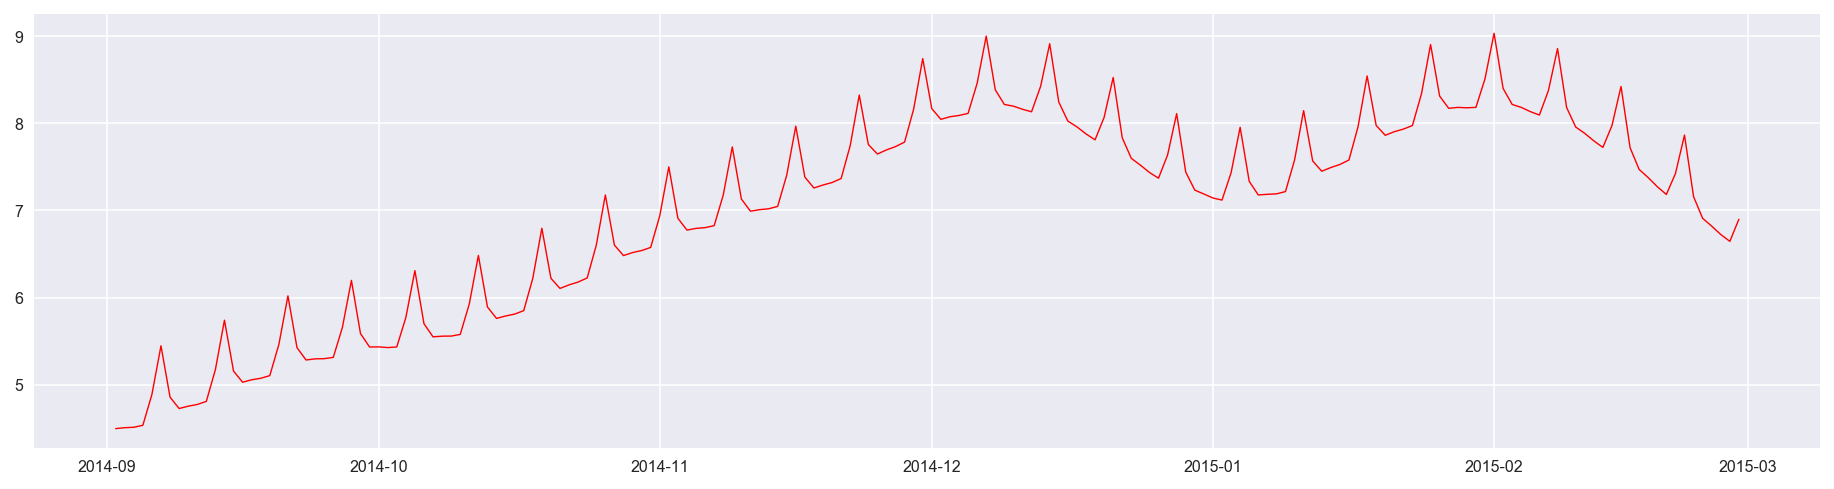

In [175]:
# plot the forecasted last 6 months
forecasted_dates = forecasted_dates.sort_values(by='ds', ascending=False)
fig, axes = plt.subplots(figsize=(16,4))
axes.plot(np.array(forecasted_dates['ds']), np.array(forecasted_dates['yhat']), 'r')

In [177]:
# show df to see which day has highest predicted consumption
forecasted_dates = forecasted_dates.sort_values(by='yhat', ascending=False) # sort descending by predicted consumption
forecasted_dates.head(5)

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
1143,2015-02-01,5.262009,4.793193,5.714166,7.984112,10.153836,3.771967,3.771967,3.771967,3.771967,3.771967,3.771967,0.634543,0.634543,0.634543,3.137424,3.137424,3.137424,9.033976
1087,2014-12-07,5.824386,5.474978,6.162965,7.908903,10.016247,3.177367,3.177367,3.177367,3.177367,3.177367,3.177367,0.634543,0.634543,0.634543,2.542824,2.542824,2.542824,9.001753
1094,2014-12-14,5.754089,5.387229,6.107249,7.886905,10.004656,3.159744,3.159744,3.159744,3.159744,3.159744,3.159744,0.634543,0.634543,0.634543,2.525201,2.525201,2.525201,8.913833
1136,2015-01-25,5.332306,4.884139,5.761713,7.791784,9.966823,3.572415,3.572415,3.572415,3.572415,3.572415,3.572415,0.634543,0.634543,0.634543,2.937872,2.937872,2.937872,8.904721
1150,2015-02-08,5.191711,4.705731,5.659187,7.823978,9.974650,3.666773,3.666773,3.666773,3.666773,3.666773,3.666773,0.634543,0.634543,0.634543,3.032230,3.032230,3.032230,8.858485


## Demand will peak on 1st February 2015 (and 7th December 2014). This matches the plot above.

Things left to do:
- report error boundary surrounding predicted day of peak consumption!
- fine-tune GAM (adjust uncertainty interval, try log instead of linear GAM) to reduce lag between actual and predicted consumption (y and yhat).
    - check error surrounding estimates are satisfactory.
- try refitting model excluding households with no data from consecutive years?
- interpolate NAs?
- explore influence of variable tariff (Std vs dToU) on predicted consumption.
- further investigation of weekly seasonality - higher weekend tariffs?